In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np


In [16]:
xarray1 = xr.open_dataset(
    "D:/Pavlicek, Emma/SDSS1411/Blue/calibrated_mod1b.nc")
xarray2 = xr.open_dataset(
    "D:/Pavlicek, Emma/SDSS1411/Blue/calibrated_mod2b.nc")
# Sort each xarray by the 'time' coordinate
xarray1_sorted = xarray1.sortby('time')
xarray2_sorted = xarray2.sortby('time')

# Concatenate the sorted xarrays
combined_xarray = xr.concat([xarray1_sorted, xarray2_sorted], dim='time')

combined_xarray.attrs['description'] = 'Combined spectra from two spectrographs.'
combined_xarray.attrs['instrument'] = 'MOD1 and MOD2'
# The new xarray is sorted in ascending order of time
sorted_combined_xarray = combined_xarray.sortby('time')

sorted_combined_xarray.to_netcdf('combined_blue_spectra.nc')

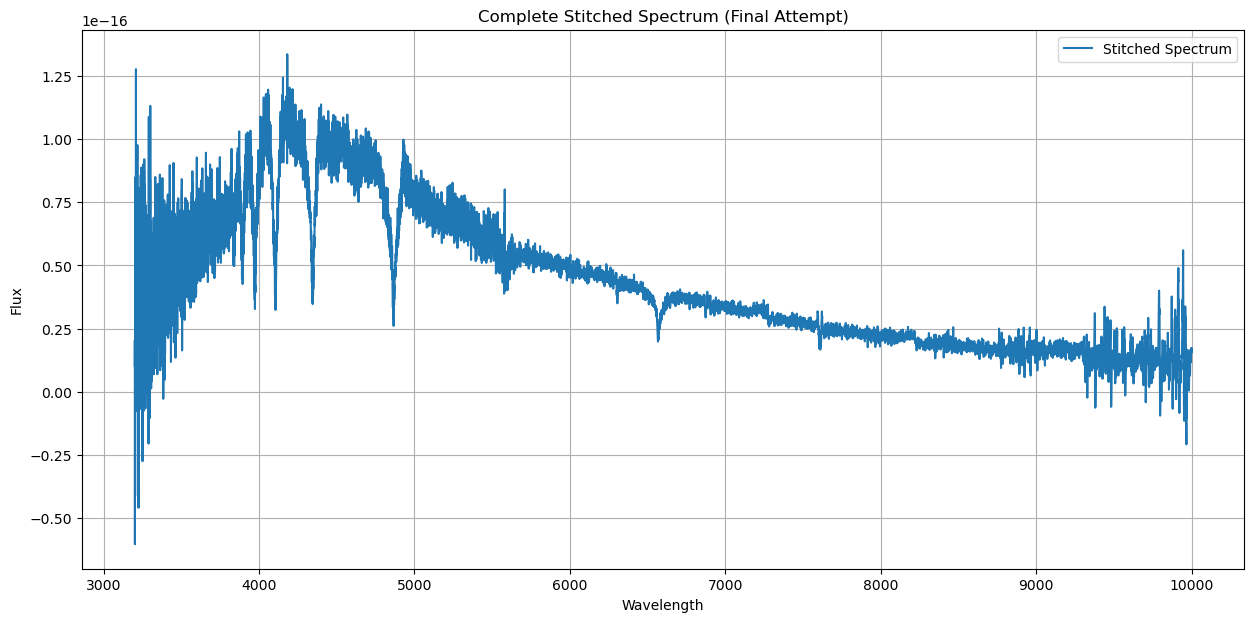

Final stitched spectrum saved to: D:/Pavlicek, Emma/WD1202/WD1202_spectra.nc


In [31]:
# Load your two cleaned and clipped datasets
blue_side_ds = xr.open_dataset("D:/Pavlicek, Emma/WD1202/blue.nc")
red_side_ds = xr.open_dataset("D:/Pavlicek, Emma/WD1202/red.nc")

# 1. Create a list to hold the stitched DataArrays for each time step
stitched_spectra_list = []

# 2. Loop through each time step in the blue-side data
for i, time_val in enumerate(blue_side_ds.time):
    # Select the single spectrum for this time step from the blue side
    blue_spectrum = blue_side_ds.isel(time=i)

    # Find the corresponding red-side spectrum by finding the nearest time value
    red_spectrum = red_side_ds.sel(time=time_val, method='nearest')
    
    # 3. Select the data to use from each side to prevent overlap
    # Slice the blue spectrum to keep data only up to 5600
    blue_spectrum_selection = blue_spectrum.sel(wavelength=slice(None, 5600))
    # Slice the red spectrum to keep data from 5600 onwards
    red_spectrum_selection = red_spectrum.sel(wavelength=slice(5600, None))

    shifted_red_wavelengths = red_spectrum_selection.wavelength.values

    # 4. Concatenate the flux and error arrays for this time step from the selected data
    stitched_flux_values = np.concatenate([blue_spectrum_selection['flux_calibrated'].values, red_spectrum_selection['flux_calibrated'].values])
    stitched_err_values = np.concatenate([blue_spectrum_selection['flux_calibrated_error'].values, red_spectrum_selection['flux_calibrated_error'].values])

    # 5. Create a new DataArray with the combined data and a single time coordinate
    stitched_da = xr.Dataset(
        data_vars={
            'flux_calibrated': (['wavelength'], stitched_flux_values),
            'flux_calibrated_error': (['wavelength'], stitched_err_values)
        },
        coords={
            'time': time_val,
            'wavelength': np.concatenate([blue_spectrum_selection.wavelength.values, shifted_red_wavelengths])
        }
    )

    # 6. Append the new Dataset to our list
    stitched_spectra_list.append(stitched_da)

# 7. Concatenate all the single-time-step Datasets into one master Dataset
final_stitched_ds = xr.concat(stitched_spectra_list, dim='time')
final_stitched_ds = final_stitched_ds.sortby('wavelength')
# --- Plot the stitched spectrum to verify the result ---
plt.figure(figsize=(15, 7))
stitched_spectrum_plot = final_stitched_ds['flux_calibrated'].isel(time=0)

plt.plot(stitched_spectrum_plot.wavelength, stitched_spectrum_plot.values, label='Stitched Spectrum')
plt.title('Complete Stitched Spectrum (Final Attempt)')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend()
plt.grid(True)
plt.show()

# --- Save the final stitched dataset ---
output_file_path = "D:/Pavlicek, Emma/WD1202/WD1202_spectra.nc"
final_stitched_ds.to_netcdf(output_file_path)

print(f"Final stitched spectrum saved to: {output_file_path}")

The closest wavelength in your data to H-alpha is: 6564.664572167807 Å
The flux at this wavelength is: 2.314109344544389e-17


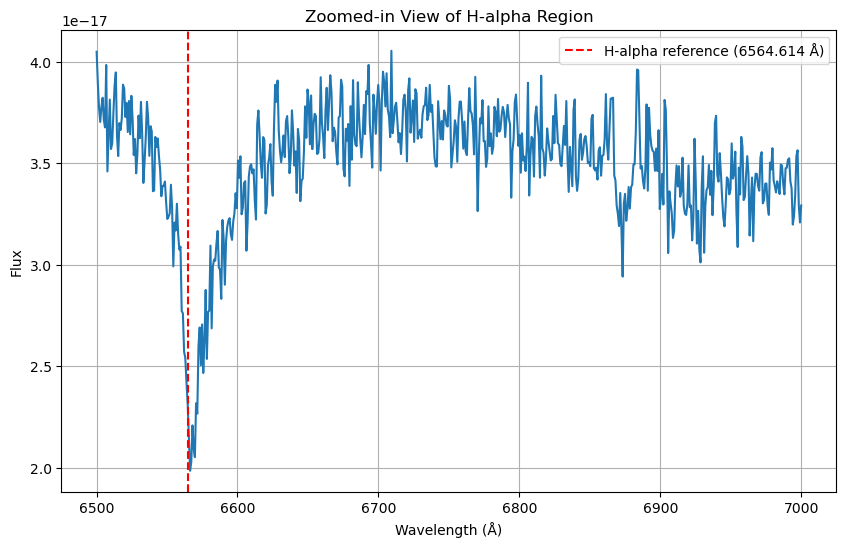

In [30]:
# The known vacuum wavelength of H-alpha in Angstroms
h_alpha_wavelength_reference = 6564.614

# Find the index of the closest wavelength in your dataset
h_alpha_idx = np.abs(final_stitched_ds.wavelength.values - h_alpha_wavelength_reference).argmin()

# Get the corresponding wavelength and flux from your data
h_alpha_wavelength_in_data = final_stitched_ds.wavelength.values[h_alpha_idx]
h_alpha_flux_in_data = final_stitched_ds.flux_calibrated.isel(time=0).values[h_alpha_idx]

print(f"The closest wavelength in your data to H-alpha is: {h_alpha_wavelength_in_data} Å")
print(f"The flux at this wavelength is: {h_alpha_flux_in_data}")

# Plot a zoomed-in section around H-alpha to visually check
plt.figure(figsize=(10, 6))
# Select a small range around the H-alpha line to plot
final_stitched_ds['flux_calibrated'].isel(time=0).sel(wavelength=slice(6500, 7000)).plot(x='wavelength')
plt.axvline(h_alpha_wavelength_reference, color='r', linestyle='--', label=f'H-alpha reference ({h_alpha_wavelength_reference} Å)')
plt.title('Zoomed-in View of H-alpha Region')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#TO FIX MESSED UP TIME COORDINATE: USE LIST OF OG (arbitray side choice) TIME COORDINATES
import xarray as xr
import pandas as pd

original_dataset = xr.open_dataset("D:/Pavlicek, Emma/WD1202/blue_cleaned.nc")
# This is your new list of time values.
# You can use any list, but for time, a pandas.to_datetime object is a good practice.
new_time_list = [0, 262, 706, 959, 1413, 1656, 2119, 2352, 2825, 3147, 3532, 3844, 4239, 4541, 4946, 5237, 5652, 5934, 6359, 6730, 7066, 7428]

# Create a new DataArray with the "time" dimension
new_time_coords = xr.DataArray(new_time_list, coords={"time": new_time_list}, dims=["time"])

# Replace the 'time' coordinate
updated_dataset = original_dataset.assign_coords(time=new_time_coords)

new_output_path = "D:/Pavlicek, Emma/WD1202/blue_spectra.nc"
updated_dataset.to_netcdf(new_output_path)